### Import Packages

In [1]:
import pandas as pd
import numpy as np

import os
# Text preprocessing packages
import nltk # Text libarary
# nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re  # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

nltk.download('stopwords')
nltk.download('wordnet')

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\K I N
[nltk_data]     G\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\K I N
[nltk_data]     G\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Read Dataset

In [23]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 3.25 s


In [24]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [25]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [26]:
df_text.drop_duplicates(subset = ['Text'], inplace = True)

In [27]:
len(df_text)

393579

### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [28]:
df_text['target'] = [0 if x < 3 else 1 for x in df_text['Score']]

In [29]:
df_text.head()

,Text,Score,target
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


#### Plot Countplot for target Variable

<AxesSubplot:xlabel='target', ylabel='count'>

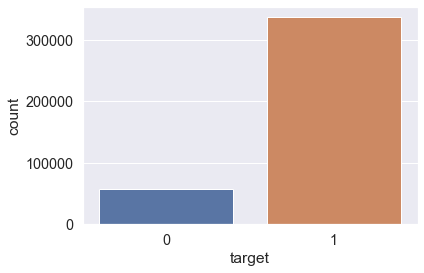

In [30]:
sns.countplot(x = 'target', data = df_text)

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [362]:
df_text.reset_index(drop = True, inplace =True)

In [363]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]]).reset_index()

In [364]:
df_text_balanced.head()

,index,Text,Score,target
0,103517,I was skeptical at first -- could we commit to...,5,1
1,374703,I have been eating Kameda Kaki-no-tane (its ja...,5,1
2,180188,This is the best price I've found on Kuerig cu...,5,1
3,210266,This is the best tasting gluten free pizza dou...,5,1
4,160255,This is a perfect Chai Latte! No need to add ...,5,1


In [365]:
df_text_balanced.drop('index', axis = 1, inplace = True)

<AxesSubplot:xlabel='target', ylabel='count'>

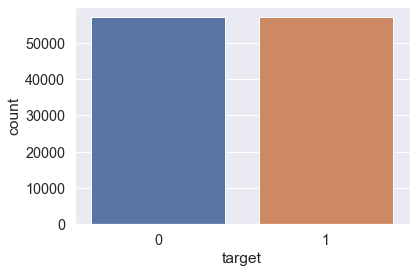

In [366]:
## PLot the target again after balancing
sns.countplot(x = 'target', data = df_text_balanced)

In [367]:
df_text_balanced.isna().sum()

Text      0
Score     0
target    0
dtype: int64

### Text Pre-Processing

In [368]:
def Remove(text):
    text = re.sub("\\<.*?\\>", "", text)  # Removing tags html from string
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)  # Removing links from string
    text = re.sub("[^A-Za-z']+", " ", text)   # Removing any brackets or special character or numbers 
    text = re.sub(r'(Mr|Ms|Mrs)\.?\s[A-Z]\w*', " ", text) # Removing names from strings 
    text = " ".join(text.split()) # adjusting the spaces in string
    return text

df_text_balanced['Text']= df_text_balanced['Text'].str.lower().str.strip().apply(Remove)

In [369]:
list_of_stops = ["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've","let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed","index","information","instead","invention","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","moreover","mostly","mr","mrs","much","mug","must","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","nobody","non","none","nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","old","omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","said","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder"]

In [370]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
stop_words.update(list_of_stops)
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

In [371]:
def stopWords(text):
    x = ' '
    ls = list()
    for word in text.split():
        if word not in stop_words:
            ls.append(word)
    return x.join(ls)
    
df_text_balanced['Text'] = df_text_balanced['Text'].apply(stopWords)

In [372]:
df_text_balanced.head()

,Text,Score,target
0,skeptical commit bags coffee organic mocha jav...,5,1
1,eating kameda kaki tane japanese decades versi...,5,1
2,price kuerig cups arrives time earlier expecte...,5,1
3,tasting gluten free pizza dough simple find go...,5,1
4,perfect chai latte add cream sugar perfect coo...,5,1


In [373]:
def lemmatization(text):
    x = ' '
    ls = list()
    for word in text.split():
        ls.append(lemmatizer.lemmatize(word))
    return x.join(ls)
    
df_text_balanced['Text'] = df_text_balanced['Text'].apply(lemmatization)

In [374]:
df_text_balanced.head()

,Text,Score,target
0,skeptical commit bag coffee organic mocha java...,5,1
1,eating kameda kaki tane japanese decade versio...,5,1
2,price kuerig cup arrives time earlier expected...,5,1
3,tasting gluten free pizza dough simple find go...,5,1
4,perfect chai latte add cream sugar perfect coo...,5,1


In [375]:
def stemming(text):
    x = ' '
    ls = list()
    for word in text.split():
        ls.append(stemmer.stem(word))
    return x.join(ls)

df_text_balanced['Text'] = df_text_balanced['Text'].apply(stemming)

In [376]:
df_text_balanced.head()

,Text,Score,target
0,skeptic commit bag coffe organ mocha java tast...,5,1
1,eat kameda kaki tane japanes decad version mee...,5,1
2,price kuerig cup arriv time earlier expect cof...,5,1
3,tast gluten free pizza dough simpl find good g...,5,1
4,perfect chai latt add cream sugar perfect cool...,5,1


### Split Test & Training Data

In [377]:
X = df_text_balanced['Text']
y = df_text_balanced['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [378]:
## TFIDF embedding for the Description
vectorizer = TfidfVectorizer()
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf = vectorizer.fit(X)
# transform on training data
X_train = vectorizer_tfidf.transform(X_train)
# transform on testing data
X_test = vectorizer_tfidf.transform(X_test)

In [379]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((79893, 47553), (34241, 47553))

### Modelling

In [380]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [395]:
## initialize your Model
clf = RandomForestClassifier(random_state=1) 
# Fit your Model on the Training Dataset
clf.fit(X_train, y_train)
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 82.75%


### Raw Instance Prediction

In [382]:
def raw_test(review, model, vectorizer):
    # Clean Review
    review_c = stemming(lemmatization(stopWords(Remove(review.lower().strip()))))
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative" 

In [3]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [384]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [385]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [386]:
import pickle

In [387]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('C:/Users/K I N G/Nawah Projects/Food Review/pickling/', model_name)
vect_path = os.path.join('C:/Users/K I N G/Nawah Projects/Food Review/pickling/', vectorizer_name)

pickle.dump(clf, open(model_path, 'wb')) ## Save model
pickle.dump(vectorizer_tfidf, open(vect_path,'wb')) ## Save tfidf-vectorizer

### Load model Again and test them

In [388]:
loaded_model = pickle.load(open(model_path, 'rb'))
loaded_vect = pickle.load(open(vect_path, 'rb'))

In [389]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [390]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

### Deployment

In [6]:
%%writefile NLP_analysis.py

# cd 'C:\Users\K I N G\Nawah Projects\Food Review'

import streamlit as st
import pickle
import nltk # Text libarary
import string # Removing special characters {#, @, ...}
import re  # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

model_path = 'C:/Users/K I N G/Nawah Projects/Food Review/pickling/rf_model.pk'
vect_path = 'C:/Users/K I N G/Nawah Projects/Food Review/pickling/tfidf_vectorizer.pk'

loaded_model = pickle.load(open(model_path, 'rb'))
loaded_vect = pickle.load(open(vect_path, 'rb'))

def Remove(text):
    text = re.sub("\\<.*?\\>", "", text)  # Removing tags html from string
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)  # Removing links from string
    text = re.sub("[^A-Za-z']+", " ", text)   # Removing any brackets or special character or numbers 
    text = re.sub(r'(Mr|Ms|Mrs)\.?\s[A-Z]\w*', " ", text) # Removing names from strings 
    text = " ".join(text.split()) # adjusting the spaces in string
    return text

list_of_stops = ["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've","let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed","index","information","instead","invention","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","moreover","mostly","mr","mrs","much","mug","must","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","nobody","non","none","nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","old","omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","said","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder"]

stop_words = set(stopwords.words('english'))
stop_words.remove('not')
stop_words.update(list_of_stops)
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

def stopWords(text):
    x = ' '
    ls = list()
    for word in text.split():
        if word not in stop_words:
            ls.append(word)
    return x.join(ls)

def lemmatization(text):
    x = ' '
    ls = list()
    for word in text.split():
        ls.append(lemmatizer.lemmatize(word))
    return x.join(ls)

def stemming(text):
    x = ' '
    ls = list()
    for word in text.split():
        ls.append(stemmer.stem(word))
    return x.join(ls)

def raw_test(review, model, vectorizer):
    review_c = stemming(lemmatization(stopWords(Remove(review.lower().strip()))))
    embedding = vectorizer.transform([review_c])
    prediction = model.predict(embedding)
    return "Positive" if prediction == 1 else "Negative" 

def main():
    st.title('Amazon Food Review')
    st.subheader("Analyze The Text")
    text = st.text_area('')
    predict = raw_test(text, loaded_model, loaded_vect)
    if st.button('Analyze'):
            st.success(predict)
        else: st.warning('Negative')

if __name__=='__main__': 
    main()

Overwriting NLP_analysis.py


In [1]:
!streamlit run NLP_analysis.py